<a href="https://colab.research.google.com/github/GilCS/stratUp/blob/master/classification_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#About this Project

in this project we analyzed restaurant data (file zomato.csv) in India, that contains information about restaurants, mainly their locations, menus, guests, cost of a meal for two, and rating.
our business question was pricing  - we classified restaurant variables in order to predict the cost of a dinner date.  This prediction should be helpful to identify restaurants that are over or under priced for restaurant owners and customers.

1.   **step 1:** cleaning the data - the dataset was text based, and contained several fields (like "url") that had no data gain. all fields were changed to numeric or categorical. the most important fields - cost and rate we normalized for better accuracy.
2. **step 2:** data visualization - we added visualizations to better understand data spread and correlation.
3.  **step 3:** using classification and prediction algorithms - we used four different algorithms, each with its own advantages, in order to get the best result.
random forest is a based on trees classification, that combines the classification made by multiple trees.
support vector machine is the most suitable algorithm that classifies data points in a multidimensional space.
the XGBoost algorithm is a high accuracy predictive model that has a high prediction accuracy rate.
4. **step 4:** assessing the outcomes, deciding which model to use for best results.


In [3]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import make_pipeline, FeatureUnion
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.svm import SVC # Import SVC here
from sklearn.metrics import mean_absolute_error,accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, recall_score, f1_score # Import necessary metrics





In [4]:
#df = pd.read_csv(r"C:\Users\drore\OneDrive\מסמכים\GitHub\Projects\Classification Project\zomato.csv")
df = pd.read_csv('zomato.csv')


# step 1: EDA
1) Drop the columns will not relevant data e.g. ➡️ `url`, `address`, `name`, `dish_liked`, `phone`, `reviews_list`, `menu_item`
2) Drop all samples without `approx_cost`, `rest type` and `cuisines`, from 51717 to 51148 samples (less than 1%)   
3) Change the columns type accordingly:
  `online_order` from str to boll  
  `table_order` from str to boll  
  `rate` from str to num + select the number before the `/`, missing data (~15%) will be completed by K near neighbors (`KNNImputer`)  
  `approx_cost` turn to int instead of str  
  `votes` stays the same  
  `location` ➡️ decided to drop, some locations are large areas like *West Bangalore* and some are small like *Old Madras Rd*  
  `rest_type` ➡️ to make a dummy features according to five clusters (remove )
  `dish_liked` decided to drop, less than 50% of missing data. thought about chancing from str to num ➡️ turn to the sum of all liked dishes in the restaurant  
  `cuisines` ➡️ 107 unique cuisines
  `approx_cost(for two people)` stays the same  
  `listed_in(type)` ➡️ to make a dummy features  
  `listed_in(city)` ➡️ to make a dummy features  

In [5]:
df.head(1)

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari


In [6]:
df = df.drop(
    [
        "url",
        "address",
        "name",
        "phone",
        "reviews_list",
        "dish_liked",
        "menu_item",
        "location",
    ],
    axis=1,
)

In [7]:
df = df[df["approx_cost(for two people)"].notnull()]
df = df[df["rest_type"].notnull()]
df = df[df["cuisines"].notnull()]

In [8]:
df['approx_cost(for two people)'] = df['approx_cost(for two people)'].replace({',': ''}, regex = True).astype(int)

In [9]:
for col in ["online_order", "book_table"]:
    df[col] = df[col].map({"Yes": 1, "No": 0})

In [10]:
df["rate"] = df["rate"].apply(
    lambda i: float(re.search(r"(\d+\.\d+)", str(i)).group(1))
    if re.search(r"(\d+\.\d+)", str(i))
    else None
)


In [11]:
imputer_rate = KNNImputer(missing_values=np.nan , n_neighbors=5)
df[['rate_imputer']] = imputer_rate.fit_transform(df[['rate']])
df["rate"] = KNNImputer(missing_values=np.nan , n_neighbors=5)


In [12]:
# Defining mapping function
def mapping(types, dic):
    """Create a list of the clusters that each restaurant type or cuisine belongs to.
    Args:
        types (list):list of the restaurant type
    Returns:
        list: list of the clusters names
    """
    result = []
    for type in types:
        for key, values in dic.items():
            for value in values:
                if type in value:
                    result.append(key)
    return result

In [13]:
cuisines_type_dic = {
    "Indian": [
        "North Indian",
        "South Indian",
        "Andhra",
        "Mughlai",
        "Kerala",
        "Chettinad",
        "Rajasthani",
        "Hyderabadi",
        "Gujarati",
        "Maharashtrian",
        "Oriya",
        "Bengali",
        "Goan",
        "Kashmiri",
        "Modern Indian",
        "Malwani",
        "Lucknowi",
        "Bihari",
        "Mangalorean",
        "Biryani",
    ],
    "Asian": [
        "Chinese",
        "Thai",
        "Asian",
        "Japanese",
        "Korean",
        "Indonesian",
        "Vietnamese",
        "Singaporean",
        "Mongolian",
        "Cantonese",
        "Tibetan",
        "Filipino",
        "Pan Asian",
        "Sri Lankan",
    ],
    "Western": [
        "Continental",
        "Italian",
        "American",
        "French",
        "British",
        "Mexican",
        "Spanish",
        "Australian",
        "Belgian",
        "German",
        "Swiss",
        "Tex-Mex",
        "South American",
        "Portuguese",
    ],
    "Fast Food": [
        "Fast Food",
        "Burger",
        "Pizza",
        "Street Food",
        "Finger Food",
        "Sandwich",
        "BBQ",
        "Wraps",
        "Hot dogs",
        "Bar Food",
    ],
    "Drinks and Desserts": [
        "Beverages",
        "Juices",
        "Ice Cream",
        "Tea",
        "Coffee",
        "Desserts",
        "Mithai",
        "Bubble Tea",
        "Paan",
    ],
    "Middle Eastern": ["Lebanese", "Arabian", "Turkish", "Middle Eastern", "Afghan"],
    "Others": ["Seafood", "Healthy Food", "Steak", "African", "Grill", "Raw Meats"],
}


In [14]:
# Creating list of restaurants cuisines
df["rest_cuisines_list"] = df["cuisines"].str.split(", ")

# Creating empty columns for the new cuisines clusters
for key, value in cuisines_type_dic.items():
    df[key] = 0

# Using the function to create a new column
df["rest_cuisines_cluster"] = df["rest_cuisines_list"].apply(
    lambda i: mapping(i, cuisines_type_dic)
)

# According to the types, insert '1' to the correct column to create dummy features
for index, values in df["rest_cuisines_cluster"].items():
    for value in values:
        if value in cuisines_type_dic.keys():
            df.loc[index, value] = 1

![image.png](attachment:image.png)

In [15]:
dic_location_in_city = {
    "Central Business District (CBD)": [
        "Brigade Road",
        "MG Road",
        "Residency Road",
        "Church Street",
        "Lavelle Road","New BEL Road"
    ],
    "Outer Ring Road (ORR)": [
        "Bannerghatta Road",
        "Bellandur",
        "Electronic City",
        "HSR Layout",
        "Marathahalli",
        "Sarjapur Road",
        "Whitefield",
    ],
    "Tech Parks": ["Electronic City", "Whitefield", "Marathahalli"],
    "Residential Areas": [
        "Banashankari",
        "Basavanagudi",
        "Brookfield",
        "BTM Layout",
        "Frazer Town",
        "Indiranagar",
        "Jayanagar",
        "JP Nagar",
        "Kalyan Nagar",
        "Kammanahalli",
        "Koramangala 4th Block",
        "Koramangala 5th Block",
        "Koramangala 6th Block",
        "Koramangala 7th Block",
        "Malleshwaram",
        "Rajajinagar",
        "HAL Old Airport Road",
    ],
}

In [16]:
# Creating list of places
df["rest_places_list"] = df['listed_in(city)'].str.split(", ")

# Creating empty columns for the new cuisines clusters
for key, value in dic_location_in_city.items():
    df[key] = 0

# Using the function to create a new column
df["rest_places_cluster"] = df["rest_places_list"].apply(
    lambda i: mapping(i, dic_location_in_city)
)

# According to the types, insert '1' to the correct column to create dummy features
for index, values in df["rest_places_cluster"].items():
    for value in values:
        if value in dic_location_in_city.keys():
            df.loc[index, value] = 1

In [17]:
df = pd.concat([df, pd.get_dummies(df['listed_in(type)']).astype(int)], axis=1)

In [18]:
#Keeping only the data for the classification, drooping previous original columns
#df = df.drop(['rest_places_list','rest_type','cuisines','listed_in(city)','rate','rest_cuisines_cluster','rest_places_cluster','listed_in(type)','rest_cuisines_list'],axis=1 )
df = df.drop(['rest_places_list','rest_type','rate','cuisines','listed_in(city)','rest_cuisines_cluster','rest_places_cluster','listed_in(type)','rest_cuisines_list'],axis=1 )

In [19]:
#Normalization
scaler_stand = StandardScaler()
df[['votes', 'approx_cost(for two people)']] = scaler_stand.fit_transform(df[['votes', 'approx_cost(for two people)']])
scaler_minmax = MinMaxScaler()
df[['rate_imputer']] = scaler_minmax.fit_transform(df[['rate_imputer']])


In [20]:
#Divide the cost into 10 bins
df['cost_binned_q'] = pd.qcut(df['approx_cost(for two people)'], q=10, labels=False, duplicates='drop')
df = df.drop('approx_cost(for two people)', axis=1)

In [21]:
df_duplicate = df.copy()

#Step 2: Data visualization

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51148 entries, 0 to 51716
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   online_order                     51148 non-null  int64  
 1   book_table                       51148 non-null  int64  
 2   votes                            51148 non-null  float64
 3   rate_imputer                     51148 non-null  float64
 4   Indian                           51148 non-null  int64  
 5   Asian                            51148 non-null  int64  
 6   Western                          51148 non-null  int64  
 7   Fast Food                        51148 non-null  int64  
 8   Drinks and Desserts              51148 non-null  int64  
 9   Middle Eastern                   51148 non-null  int64  
 10  Others                           51148 non-null  int64  
 11  Central Business District (CBD)  51148 non-null  int64  
 12  Outer Ring Road (ORR)  

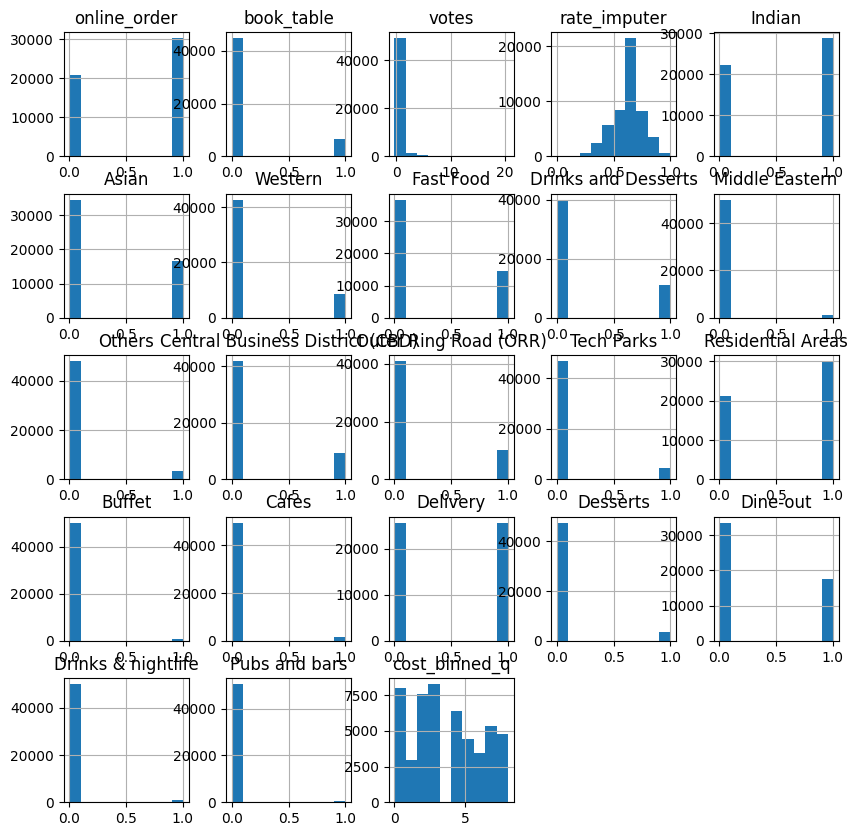

In [23]:
df.hist(figsize=(15,10))
plt.show()

<Axes: >

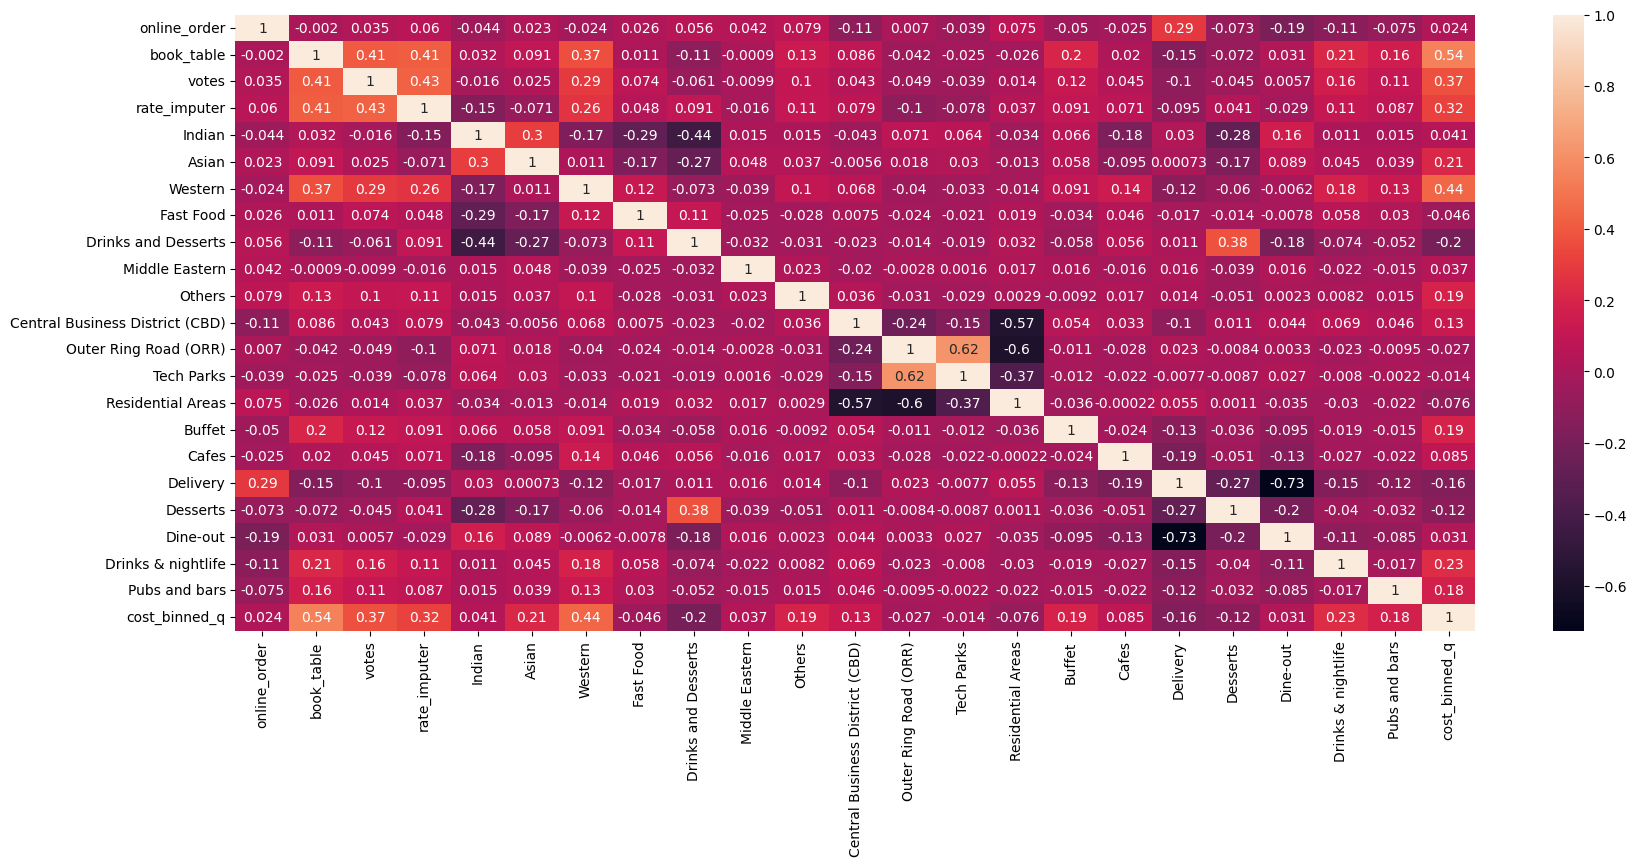

In [24]:
plt.figure(figsize=(20 , 8))
sns.heatmap(df.corr(numeric_only = True) , annot=True)

# Step 3: Classification Models


**Data Preperation**

In [66]:
X = df.drop(columns='cost_binned_q')
y = df['cost_binned_q']
print(X.shape, y.shape)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345, stratify=y)
print(f'X train shape: {X_train.shape} y train shape: {y_train.shape}')
print(f'X test shape: {X_test.shape} y test shape: {y_test.shape}')

(51148, 22) (51148,)
X train shape: (35803, 22) y train shape: (35803,)
X test shape: (15345, 22) y test shape: (15345,)


In [26]:
# Initialize a StandardScaler to normalize any feature columns if needed (though you mentioned normalization is already done)
for column in X_train.select_dtypes(include=['object']).columns:  # Check object type columns
    if any(isinstance(x, type(KNNImputer())) for x in X_train[column]):  # If any values are KNNImputer objects
        X_train[column] = pd.to_numeric(X_train[column], errors='coerce').astype('float64')
        X_test[column] = pd.to_numeric(X_test[column], errors='coerce').astype('float64')
        print(f"Converted column '{column}' to numeric")
# Impute missing values using SimpleImputer before scaling
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean') # or 'median', 'most_frequent', 'constant'
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the model - Logistic Regression in this case
model = LogisticRegression(max_iter=1000)

# Train the model
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.33398501140436626
Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.68      0.46      2392
           1       0.00      0.00      0.00       886
           2       0.27      0.27      0.27      2265
           3       0.25      0.34      0.29      2483
           4       0.23      0.15      0.18      1906
           5       0.20      0.10      0.13      1335
           6       0.30      0.06      0.10      1041
           7       0.42      0.35      0.38      1608
           8       0.66      0.71      0.68      1429

    accuracy                           0.33     15345
   macro avg       0.30      0.29      0.28     15345
weighted avg       0.30      0.33      0.30     15345



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [27]:
# Define classifiers with SMOTE added to the pipeline
classifiers = {
    'Decision Tree': {
            'model': DecisionTreeClassifier(),
            'params': {
                'classifier__max_depth': [None, 10, 20, 30]
            }
        },

    'Random Forest': {
        'model': RandomForestClassifier(),
         'params': {
            'classifier__n_estimators': [50, 100, 200],
             'classifier__max_depth': [None, 10, 20, 30]
         }
        },

    'XGBoost': {
        'model': XGBClassifier(),
        'params': {
            'classifier__n_estimators': [50, 100, 200],
            'classifier__max_depth': [3, 5, 7]
        }
    },

      'Support Vector Machine': {
            'model': SVC(),
            'params': {
                'classifier__C': [0.1, 1, 10],
                'classifier__kernel': ['linear', 'rbf']
            }
        }
}
for name, model_data in classifiers.items():
    print("\n" +f"Evaluating Model: {name}")
    model = model_data['model']
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='weighted')  # Changed 'binary' to 'weighted' for multiclass
    f1 = f1_score(y_test, y_pred, average='weighted')  # Changed 'binary' to 'weighted' for multiclass

    print(f"{name} Performance Metrics:\n")
    print(f"\tAccuracy: {accuracy:.2f}\n\tRecall: {recall:.2f}\n\tF1 Score: {f1:.2f}")



Evaluating Model: Decision Tree
Decision Tree Performance Metrics:

	Accuracy: 0.69
	Recall: 0.69
	F1 Score: 0.69

Evaluating Model: Random Forest
Random Forest Performance Metrics:

	Accuracy: 0.64
	Recall: 0.64
	F1 Score: 0.64

Evaluating Model: XGBoost
XGBoost Performance Metrics:

	Accuracy: 0.56
	Recall: 0.56
	F1 Score: 0.56

Evaluating Model: Support Vector Machine
Support Vector Machine Performance Metrics:

	Accuracy: 0.37
	Recall: 0.37
	F1 Score: 0.35


**Decision Tree**

Decision Tree Accuracy= 0.6898664059954382


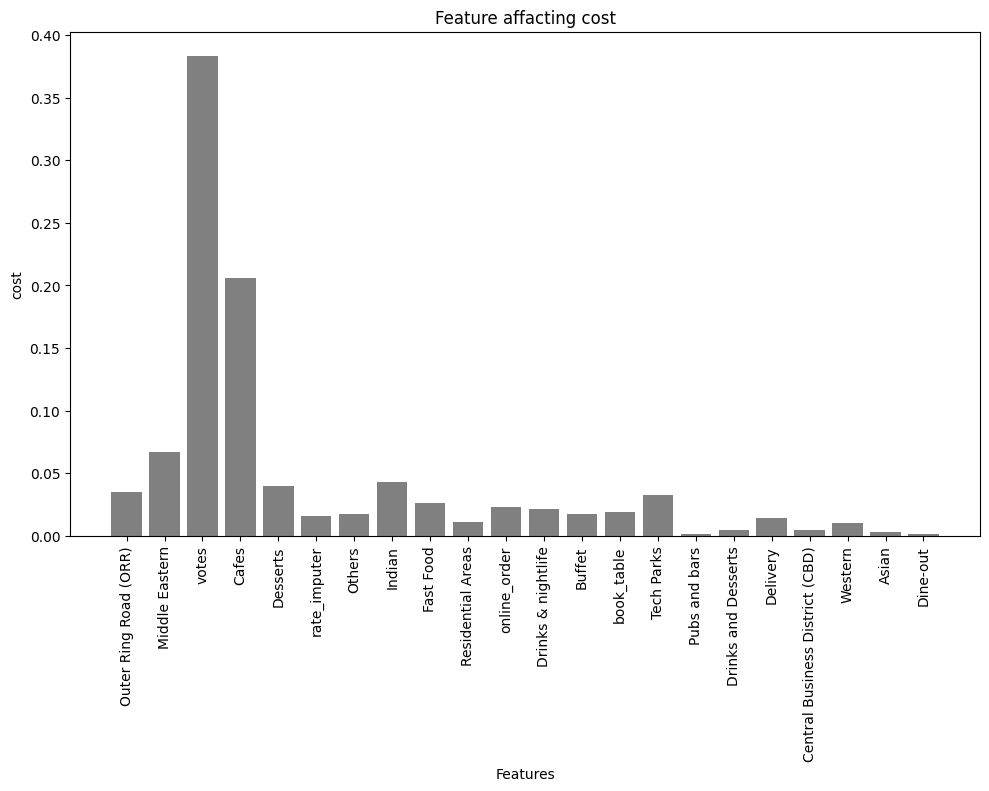

In [52]:
from sklearn.tree import DecisionTreeClassifier

DecTree = DecisionTreeClassifier(random_state=0)
result = DecTree.fit(X_train,y_train)
predictions = result.predict(X_test)
predictions
mean_absolute_error(y_test, predictions)
print("Decision Tree Accuracy=",accuracy_score(y_test,predictions))
matrix=confusion_matrix(y_test,predictions)
cost_classes = len(np.unique(y_test))
index = [f'cost class {i}' for i in range(cost_classes)]
columns = [f'Predicted Label {i}' for i in range(cost_classes)]
confusion_df = pd.DataFrame(matrix, index=index, columns=columns)
confusion_df

cost_binned_q = result.feature_importances_
features = list(set(X.select_dtypes(include=['int64', 'float64']).columns.tolist()))

plt.figure(figsize=(10, 6))
plt.bar(features, np.abs(cost_binned_q), align='center', color='gray')
plt.title(f'Feature affacting cost')
plt.xlabel('Features')
plt.ylabel('cost')
plt.tight_layout()
plt.xticks( rotation=90)

plt.show()

**Random Forest**

Random Forest Accuracy: 0.6422939068100358


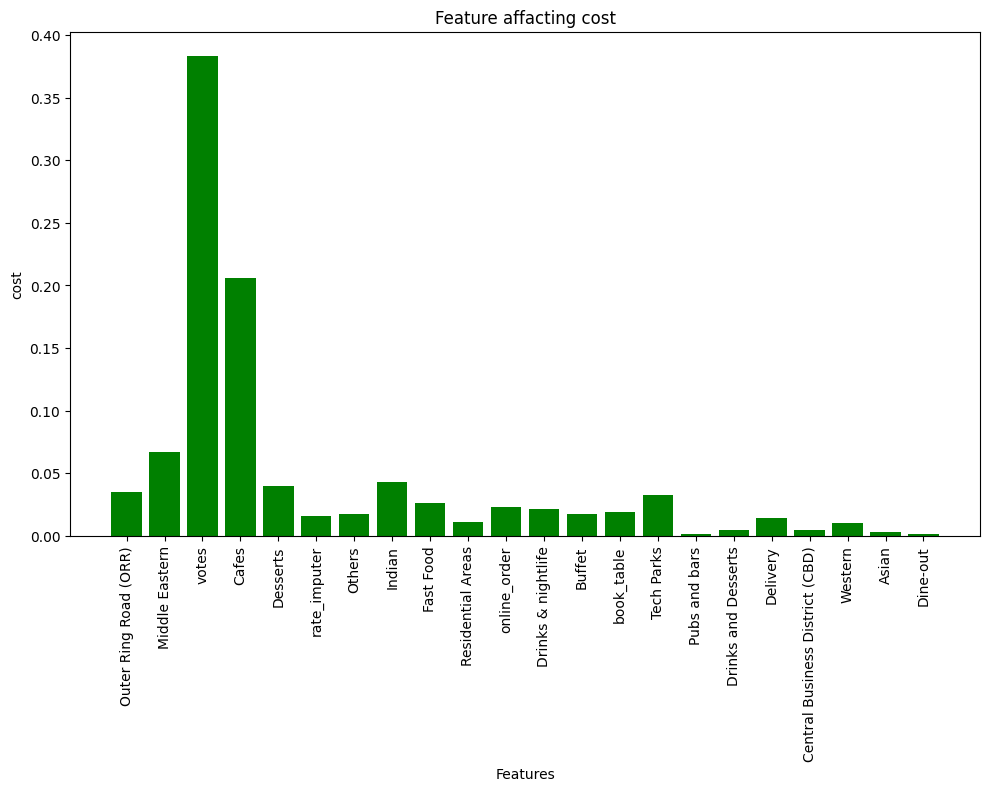

In [56]:
RandForest = RandomForestClassifier(n_estimators = 50, criterion = 'entropy', random_state = 1234)
result=RandForest.fit(X_train, y_train)
predictions = result.predict(X_test)
predictions

print("Random Forest Accuracy:",metrics.accuracy_score(y_test, predictions))
from sklearn.metrics import confusion_matrix
conf_matrix =confusion_matrix(predictions,y_test)
confusion_df = pd.DataFrame(conf_matrix, index=index, columns=columns)
confusion_df

plt.figure(figsize=(10, 6))
plt.bar(features, np.abs(cost_binned_q), align='center', color='green')
plt.title(f'Feature affacting cost')
plt.xlabel('Features')
plt.ylabel('cost')
plt.tight_layout()
plt.xticks( rotation=90)
plt.show()

**XGBoost**

In [ ]:
#XgBoost

**Support Vector Machine Classifier**

Support Vector Machine Classifier Accuracy: 0.37478005865102637


<ipython-input-71-65934efd6ae6>:27: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  y_train.astype(np.integer),
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


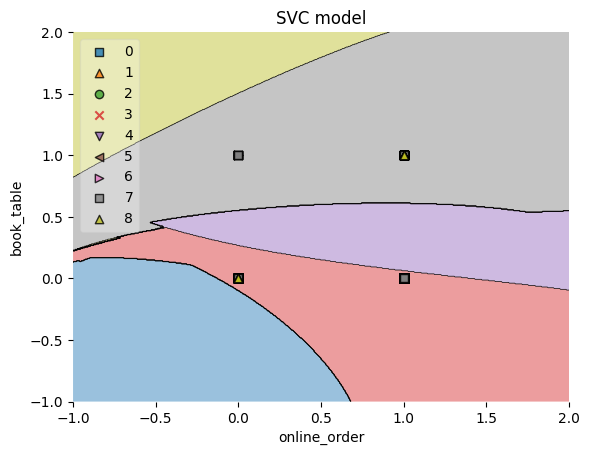

In [71]:
from mlxtend.plotting import plot_decision_regions
from sklearn.svm import SVC
import numpy as np
from sklearn.metrics import confusion_matrix

SVC = SVC(kernel = 'rbf', random_state = 0)
result = SVC.fit(X_train, y_train)
predictions = result.predict(X_test)
predictions
print("Support Vector Machine Classifier Accuracy:",accuracy_score(y_test, predictions))

from sklearn.metrics import confusion_matrix
conf_matrix =confusion_matrix(predictions,y_test)
confusion_df = pd.DataFrame(conf_matrix ,index=index, columns=columns)
confusion_df

#X_train_viz = X_train.to_numpy()
#y_train = y_train.to_numpy()
#plot_decision_regions(X_train_viz, y_train.astype(np.integer), clf=SVC, legend=2)

#plt.xlabel(X.columns[0])
#plt.ylabel(X.columns[1])
feature_index = [0, 1]
filler_values = {i: X_train.iloc[:, i].mean() for i in range(X_train.shape[1]) if i not in feature_index}
filler_ranges = {i: X_train.iloc[:, i].std() for i in range(X_train.shape[1]) if i not in feature_index}

# Plot decision regions with specified features and filler values
plot_decision_regions(X_train_viz,
                      y_train.astype(np.integer),
                      clf=SVC,
                      legend=2,
                      feature_index=feature_index, # Specify the features to visualize
                      filler_feature_values=filler_values, # Provide filler values
                      filler_feature_ranges=filler_ranges)
# Provide filler ranges


plt.xlabel(X.columns[feature_index[0]])  # Update x-axis label
plt.ylabel(X.columns[feature_index[1]])  # Update y-axis label
plt.title('SVC model')
plt.show()

In [ ]:
# Define steps for the pipeline
steps = [
  ('scaler', StandardScaler()),
  ('selector', SelectKBest(k=10)),
  ('pca', PCA(n_components=5)),
  ('classifier', DecisionTreeClassifier())
]

pipeline = Pipeline(steps)


In [ ]:
param_grid = {
    'selector__k': [5, 10, 15],
    'pca__n_components': [2, 5, 10],
    'classifier__max_depth': [5, 10, 15],
    'classifier__min_samples_split': [2, 5]
}

In [ ]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1')

grid_search.fit(X_train, y_train)


In [ ]:
from sklearn.metrics import f1_score

# Use 'micro', 'macro', or 'weighted' for multiclass classification
f1 = f1_score(y_test, y_pred, average='weighted')  # or 'micro' or 'macro'
print("Best model F1 score on test data:", f1)
